In [1]:
# Written by W.T. Chung
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import os
#### INSTRUCTIONS FOR I/O (PLEASE READ) #######
# Input data files are available in the read-only "../input/" (relative) or '/kaggle/input'(absolute) directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
input_path = '/kaggle/input/2023-flame-ai-challenge/dataset/'
output_path = '/kaggle/working/'


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.keras.utils.set_random_seed(812)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

# Reading and Plotting Data

1. Start by reading provided csv files

In [3]:
#read file ids and file names for train and val data
train_df = pd.read_csv(input_path+'train.csv')
val_df= pd.read_csv(input_path+'val.csv')
#print 5 rows of pandas dataframe
train_df.head()

,id,dx_m,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,0.000041,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,0.000041,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,0.000041,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,0.000041,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,0.000041,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


2. You can read the files with np.fromfile 

Text(0.5, 1.0, 'Z-Velocity')

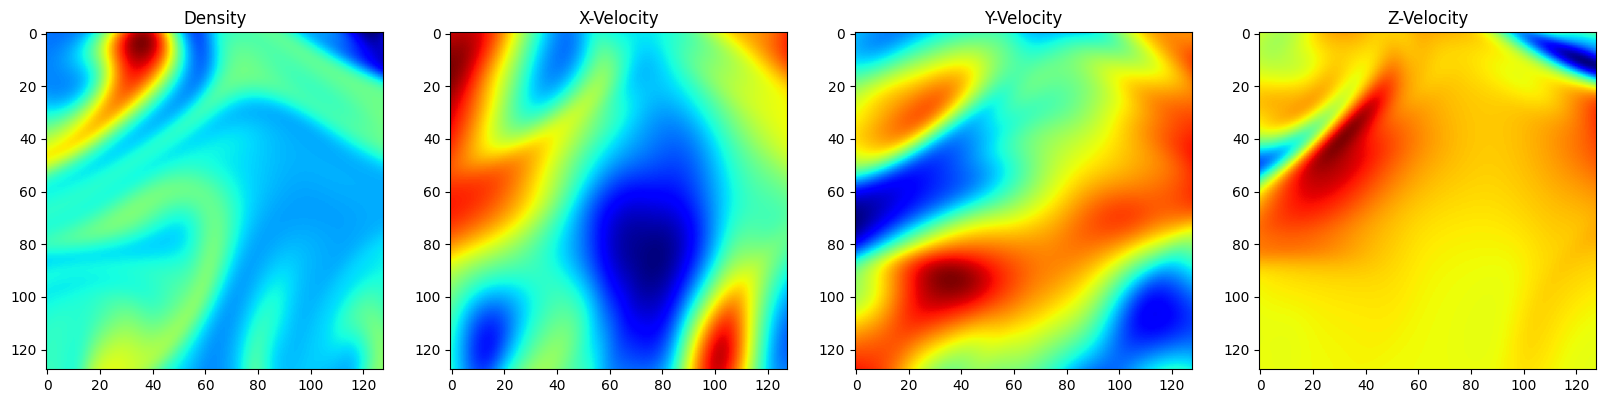

In [4]:
#plot HR labels

idx = 20
data_path = input_path+"flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')

Text(0.5, 1.0, 'UZ')

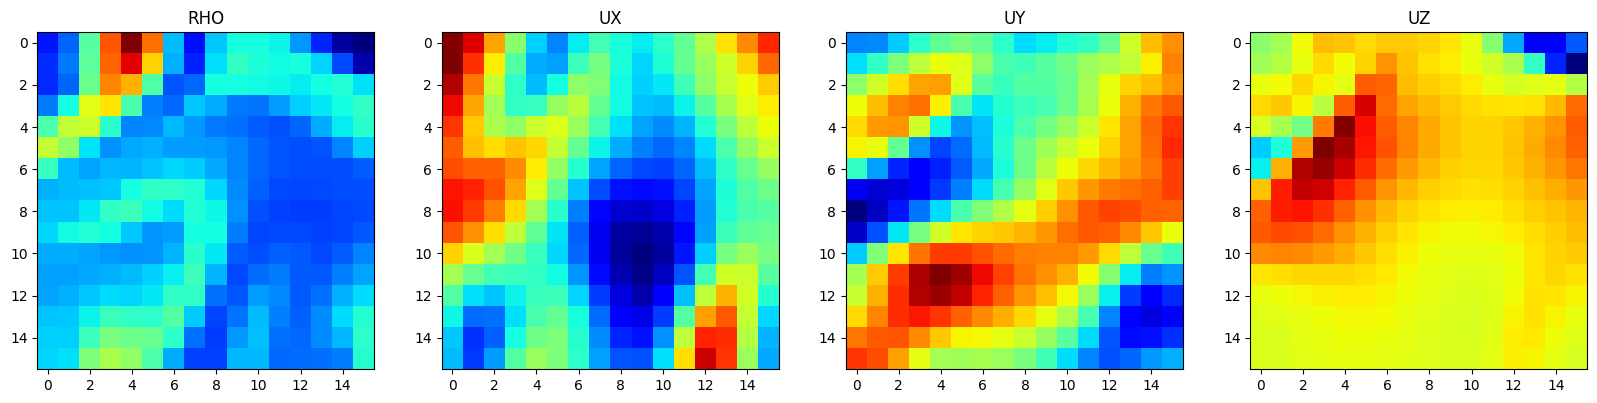

In [5]:
#plot LR features

id = 20
data_path = input_path+"flowfields/LR/train"
RHO_filename = train_df['rho_filename'][id]
UX_filename = train_df['ux_filename'][id]
UY_filename = train_df['uy_filename'][id]
UZ_filename = train_df['uz_filename'][id]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')


# Set Up Model

Here we implement a 1M param. EDSR model. Taken from keras tutorial: https://keras.io/examples/vision/edsr/

In [6]:
#taken from keras tutorial: https://keras.io/examples/vision/edsr/
from tensorflow.keras import layers
from tensorflow.keras.models import Model


# Residual Block

def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters=64, num_of_residual_blocks=16):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 4))
    # Scaling Pixel Values
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    output_layer = layers.Conv2D(4, 3, padding="same")(x)

    return Model(input_layer, output_layer)




In [ ]:
model = make_model()
model.summary()

# Set up Data Pipeline

Here we set up some data loaders from train and val

In [14]:
def getXY(idx,csv_file,mode = "train"):
    LR_path = input_path + "flowfields/LR/" + mode
    HR_path = input_path + "flowfields/HR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    #output
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128,128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128,128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128,128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128,128)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    Y = tf.stack([rho_o,ux_o,uy_o,uz_o],axis=2)
    return [X,Y]

def getTrainXY(idx):
    return getXY(idx,train_df.reset_index().to_dict(orient='list'),mode = "train")

def getValXY(idx):
    return getXY(idx,val_df.reset_index().to_dict(orient='list'),mode = "val")


The data should have x,y,channels dimensions

In [15]:
X0,Y0 = getXY(id,train_df,mode = "train")
print("Feature shapes:")
print( X0.shape)
print("Label shapes:")
print( Y0.shape)

nx_in, ny_in, nc_in = X0.shape
nx_out, ny_out, nc_out = Y0.shape

Feature shapes:
(16, 16, 4)
Label shapes:
(128, 128, 4)


Scale the data prior to training

In [16]:
my_mean = [0.24,28.0, 28.0, 28.0]
my_std = [0.068,48.0, 48.0, 48.0]
my_mean = tf.convert_to_tensor(my_mean, dtype=tf.float32)
my_std = tf.convert_to_tensor(my_std, dtype=tf.float32)
def scale_tf(X,Y,my_mean=my_mean,my_std=my_std):
    Xscaled = (X-my_mean)/my_std
    Yscaled = (Y-my_mean)/my_std
    return (Xscaled,Yscaled)

#wrapper function so tensorflow can understand this
def scale_wrapper(X,Y):
    return tf.py_function(scale_tf, inp=[X,Y], Tout=[tf.float32,tf.float32])

Build your tensorflow dataset object

In [20]:
def load_train_dataset_wrapper(file_idx):
    return tf.py_function(getTrainXY, inp=[file_idx], Tout=[tf.float32,tf.float32])

def load_val_dataset_wrapper(file_idx):
    return tf.py_function(getValXY, inp=[file_idx], Tout=[tf.float32,tf.float32])

batch_size = 32 #divisible by number of gpus
nfile = len(train_df)

train_ds = tf.data.Dataset.from_tensor_slices(range(nfile))
train_ds = (train_ds
    .shuffle(nfile)
    .map(load_train_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

nfile = len(val_df)
val_ds = tf.data.Dataset.from_tensor_slices(range(nfile))
val_ds = (val_ds
    .map(load_val_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Train Model

In [34]:
!rm -r *

In [35]:
#create directories for checkpoints and logs
log_dir = output_path + "logs" 
checkpoint_dir = output_path + "ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Either restore the latest model, or create a fresh one if there is no checkpoint available.
def make_or_restore_model(alpha=1e-3):
    model =  make_model()
    #set up save/load checkpoints
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    nckpt = 0
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        nckpt = int(latest_checkpoint.split('-')[-1])
        restored_model =  tf.keras.models.load_model(latest_checkpoint)
        model.set_weights(restored_model.get_weights())
    else:
        print("Creating a new model")
    
    #compile model with optimizerloss functions,metrics
    #NOTE: Although we're only using MSE as the public metric here, we will be also evaluating with SSIM-based metrics to search for best models so you may want to monitor other metrics
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=alpha),
        loss=tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size'),
           metrics =[tf.keras.metrics.MeanAbsoluteError()]) #add other metrics here

    return [model,nckpt]

In [36]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr*0.95

In [37]:
def run_training(train_dataset=train_ds,val_dataset=val_ds,epochs=100):
    # Create a MirroredStrategy for multi-gpu
    strategy = tf.distribute.MirroredStrategy()
    print('Number of GPUs: {}'.format(strategy.num_replicas_in_sync))
    
    # For multi-gpu: Open a strategy scope and create/restore the model
    with strategy.scope():
        [model,nckpt] = make_or_restore_model()
    #set up checkpoints and logs
    callbacks = [
        # This callback saves a SavedModel every epoch
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}", save_freq="epoch"
        ),
        # This callback is for the lr scheduler
        tf.keras.callbacks.LearningRateScheduler(scheduler),
        # This callback logs every epoch
        tf.keras.callbacks.CSVLogger(log_dir + "/model_history_log.csv", append=True)
    ]
    
    #train
    model.fit(
        train_dataset,
        epochs=epochs,
        initial_epoch=nckpt,
        callbacks=callbacks,
        verbose=1,
        validation_data = val_dataset
    )
    
    #save at the end of epoch
    model.save(output_path+'final_model')
    

Test model by training for one epoch

In [38]:
run_training(epochs=75)

Number of GPUs: 2
Creating a new model
Epoch 1/75
44/44 [==============================] - 58s 743ms/step - loss: 1.0617 - mean_absolute_error: 0.5832 - val_loss: 0.1615 - val_mean_absolute_error: 0.2772 - lr: 0.0010
Epoch 2/75
44/44 [==============================] - 34s 778ms/step - loss: 0.1535 - mean_absolute_error: 0.2635 - val_loss: 0.1027 - val_mean_absolute_error: 0.2105 - lr: 0.0010
Epoch 3/75
44/44 [==============================] - 31s 705ms/step - loss: 0.0897 - mean_absolute_error: 0.1958 - val_loss: 0.0733 - val_mean_absolute_error: 0.1741 - lr: 0.0010
Epoch 4/75
44/44 [==============================] - 31s 715ms/step - loss: 0.0596 - mean_absolute_error: 0.1561 - val_loss: 0.0484 - val_mean_absolute_error: 0.1406 - lr: 0.0010
Epoch 5/75
44/44 [==============================] - 31s 702ms/step - loss: 0.0449 - mean_absolute_error: 0.1354 - val_loss: 0.0388 - val_mean_absolute_error: 0.1239 - lr: 0.0010
Epoch 6/75
44/44 [==============================] - 32s 721ms/step - lo

# Generate submission

In [39]:
#gets test set input
def getTestX(idx):
    csv_file = test_df.reset_index().to_dict(orient='list')
    LR_path = input_path+"flowfields/LR/test" 
    id = csv_file['id'][idx]

    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    return id,X

def scale_X(X,my_mean=my_mean,my_std=my_std):
    Xscaled = (X-my_mean)/my_std
    return Xscaled

#predicts with input
def predict(idx,model):
    id,X = getTestX(idx)
    X = tf.expand_dims(X,0)
    X = scale_X(X)
    y_pred = model.predict(X)
    #added this to rescale predictions CHANGE THIS IF YOU USED DIFFERENT SCALING
    y_pred_unscaled = (y_pred*my_std)+my_mean
    return id,y_pred_unscaled

#generates submission with model predictions already in SI units
def generate_submission(model):
    my_mean = [0.24,28.0, 28.0, 28.0]
    my_std = [0.068,48.0, 48.0, 48.0]
    my_mean = np.array(my_mean)
    my_std = np.array(my_std)
    y_preds = {}
    ids = []
    for idx in range(len(test_df)):
        id,y_pred = predict(idx,model) 
        #WARNING tmp should be in SI units
        tmp = (np.array(y_pred) - my_mean)/my_std #this normalizes density and velocity to be in the same range
        y_preds[id]= np.array(tmp).flatten(order='C').astype(np.float32)
        ids.append(id)
    df = pd.DataFrame.from_dict(y_preds,orient='index')
    df['id'] = ids
    #move id to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    #reset index
    df = df.reset_index(drop=True)

    return df

In [40]:
test_df = pd.read_csv(input_path+'/test.csv')
model,_ = make_or_restore_model()
submission_df = generate_submission(model)

Restoring from /kaggle/working/ckpt/ckpt-75
1/1 [==============================] - 0s 30ms/step


Save the file for downloading!

In [41]:
submission_df.to_csv(output_path+'submission.csv',index=False)
submission_df.head()

,id,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-657116647631363807,0.501932,0.550491,-0.371992,-0.464041,0.695072,0.718888,-0.451662,-0.450826,0.759982,...,-0.464191,-0.569840,0.583134,0.628054,-0.412927,-0.463067,0.461940,0.440383,-0.349297,-0.450472
1,7483162365939134796,0.499663,0.542436,-0.383226,-0.477165,0.696818,0.716762,-0.484216,-0.473397,0.759562,...,-0.352840,-0.511598,0.624447,0.299553,-0.332220,-0.404574,0.487958,0.215071,-0.288961,-0.406905
2,-6212758420087317096,0.510054,0.408182,-0.364411,-0.434669,0.703038,0.552631,-0.449005,-0.435086,0.778024,...,-0.449046,-0.552776,0.601976,0.621546,-0.395055,-0.448275,0.478004,0.434751,-0.334827,-0.442463
3,-1825935182480952214,-0.384105,0.731927,-0.270303,-0.461384,-0.501153,0.834671,-0.373571,-0.588325,-0.550164,...,-0.582124,-0.878151,-0.722306,1.276598,-0.522025,-0.846965,-0.452318,1.026327,-0.440542,-0.638729
4,-1859240836295259171,1.256596,-0.270780,-0.368312,-0.459925,1.698901,-0.171013,-0.416112,-0.458635,1.940097,...,-0.372554,-0.546127,0.697552,-0.100187,-0.347946,-0.403594,0.557318,-0.066697,-0.295561,-0.395612


In [42]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_1058 (Conv2D)           (None, None, None,   2368        ['input_9[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1059 (Conv2D)           (None, None, None,   36928       ['conv2d_1058[0][0]']            
                                64)                                                         

Compare with sample (nearest_interp)!

In [ ]:
sample_df = pd.read_csv(input_path+'/sample_submission.csv')

In [ ]:
sample_df.head()